# Load Recorded Sensor Data

In [1]:
from sensor_data_loadder import SensorData
import matplotlib.pyplot as plt
from mpl_toolkits.mplot3d import Axes3D

DATA_DIR = './walks/outside_elab/new/'
DATA_FILE = 'trax_2025_4_25_3_37_16_#28.csv'

sensorData = SensorData(data_dir=DATA_DIR, data_file=DATA_FILE)

Average sampling period: 0.0375 seconds
Approximate sampling frequency: 26.67 Hz


## 2. Orientation Estimation using Accelerometer and Magnetometer Raw Data

In [2]:
from orientation_estimation import KalmanOrientationEstimator
import numpy as np
import matplotlib.pyplot as plt

initial_covariance = np.eye(3) * 0.1**2  # Example values for position/angle uncertainty
process_noise = np.diag([0.01**2, 0.01**2, 0.02**2])  # Accelerometer, Gyroscope, Magnetometer
measurement_noise = np.diag([0.2**2, 0.2**2, 0.3**2])  # Accelerometer, Gyroscope, Magnetometer
alpha = 0.7

kalmanFilter = KalmanOrientationEstimator(
    sensorData.acc_raw_data,
    sensorData.mag_raw_data,
    sensorData.gyro_raw_data,
    sensorData.timestamps_in_ms,
    initial_covariance=initial_covariance,
    process_noise=process_noise,
    measurement_noise=measurement_noise,
    alpha=alpha
)

roll_kf, pitch_kf, yaw_kf = kalmanFilter.compute_angles()

# 3D Visualisation

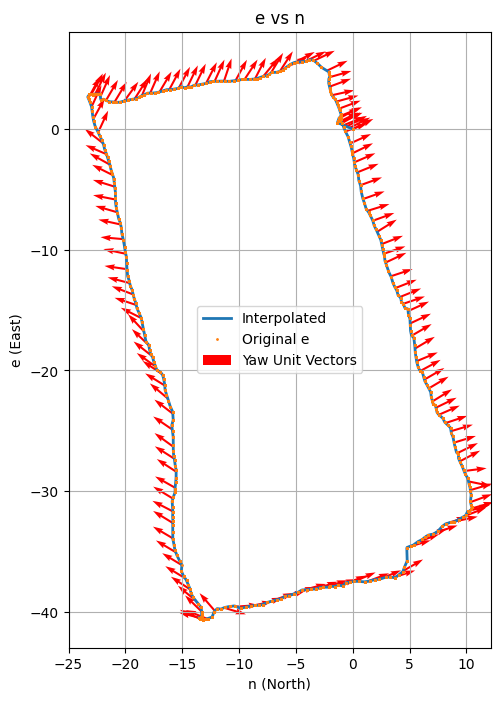

In [3]:

from pymap3d import geodetic2enu

# Example: GPS raw data: (N, 3) where each row is [lat, lon, alt]
# gps_raw_data = np.array([[lat1, lon1, alt1], [lat2, lon2, alt2], ..., [latN, lonN, altN]])

lat0, lon0, alt0  = sensorData.gps_raw_data[0]  # Origin for ENU conversion

# Initialize arrays to store ENU coordinates
e = np.zeros(sensorData.gps_raw_data.shape[0])  # East
n = np.zeros(sensorData.gps_raw_data.shape[0])  # North
u = np.zeros(sensorData.gps_raw_data.shape[0])  # Up

# Convert each GPS point (lat, lon, alt) to ENU
for i, (lat, lon, alt) in enumerate(sensorData.gps_raw_data):
    e[i], n[i], u[i] = geodetic2enu(lat, lon, alt, lat0, lon0, alt0)

gps_unique_timestamps_in_seconds = np.unique(sensorData.gps_timestamps_in_seconds)

# Stack the results into a single (N, 3) array for ENU positions
# Interpolation
interpolated_e = np.interp(sensorData.timestamps_in_seconds, sensorData.gps_timestamps_in_seconds, e)
interpolated_n = np.interp(sensorData.timestamps_in_seconds, sensorData.gps_timestamps_in_seconds, n)


# Angles are defined as follows
angles = np.array([roll_kf, pitch_kf, yaw_kf])  # roll, pitch, yaw
angles = np.transpose(angles)
# Assume yaw_kf is in radians
yaw_unit_x = np.cos(yaw_kf)
yaw_unit_y = np.sin(yaw_kf)

# Every 20th index
idx = np.arange(0, len(interpolated_e), 20)


# Plot 3D trajectory with reference frames
fig = plt.figure(figsize=(12, 8))

# Plot e vs n
plt.subplot(1, 2, 1)
plt.plot(interpolated_e, interpolated_n, '-', label='Interpolated', linewidth=2)
plt.plot(e, n, 'o', label='Original e', markersize=1)

# Plot unit yaw vectors as quivers
plt.quiver(interpolated_e[idx], interpolated_n[idx], 
           yaw_unit_x[idx], yaw_unit_y[idx], 
           angles='xy', scale_units='xy', color='r', label='Yaw Unit Vectors', scale=0.5)

plt.title('e vs n')
plt.xlabel('n (North)')
plt.ylabel('e (East)')
plt.legend()
plt.grid()
plt.show()

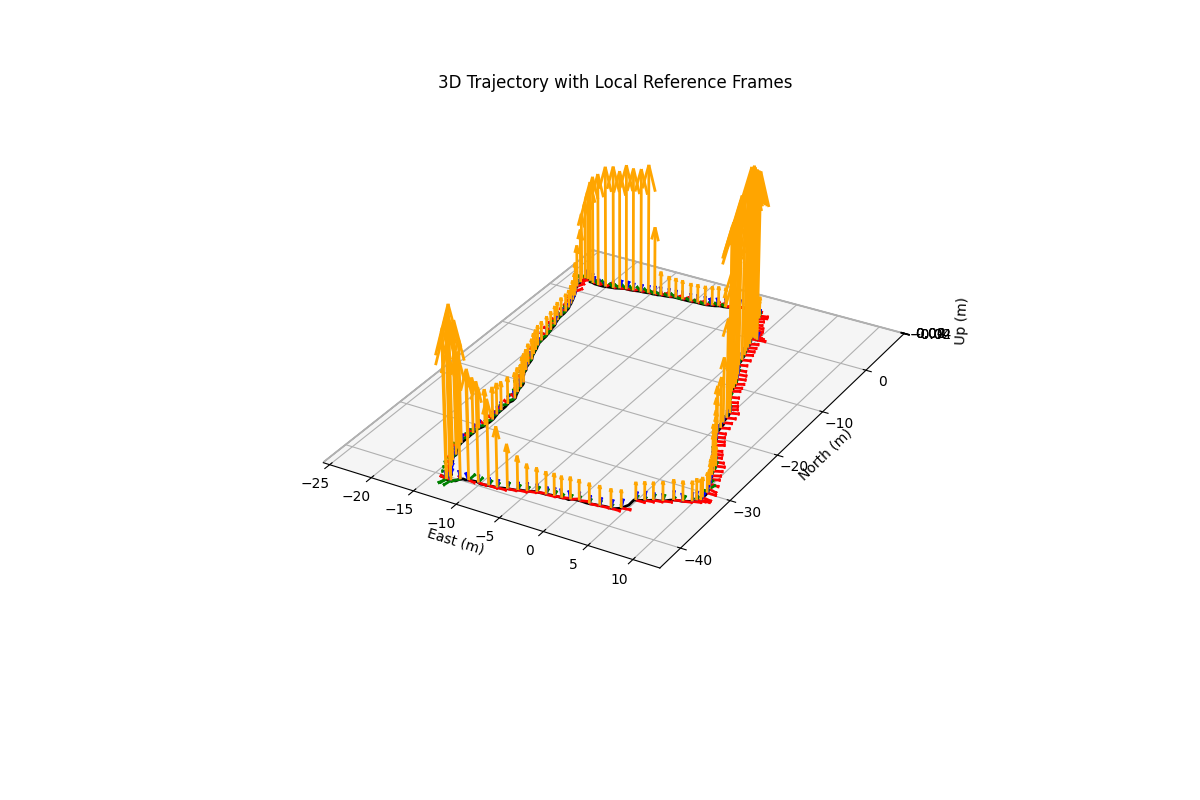

In [ ]:
import matplotlib.pyplot as plt
from scipy.spatial.transform import Rotation as R

%matplotlib widget 

idx = np.arange(0, len(interpolated_e), 20)
# print(idx)

# Rotation vectors for local frames
unit_x = np.zeros((len(idx), 3))
unit_y = np.zeros((len(idx), 3))
unit_z = np.zeros((len(idx), 3))

for j, i in enumerate(idx):
  r = R.from_euler('xyz', angles[i])
  Rmat = r.as_matrix()

  unit_x[j] = Rmat[:, 0]
  unit_y[j] = Rmat[:, 1]
  unit_z[j] = Rmat[:, 2]


# to interact  with plot 
# matplotlib widget

# Plot 3D trajectory with reference frames
fig = plt.figure(figsize=(12, 8))
ax = fig.add_subplot(111, projection='3d')

# Plot path
ax.plot(interpolated_e, interpolated_n, color='black', linewidth=2, label='Trajectory')

# Plot quivers for every 20th point
scale = 1.0

for i in range(len(idx)):
  x0, y0, z0 = interpolated_e[idx[i]], interpolated_n[idx[i]], 0

  # Local frame vectors (unit_x, unit_y, unit_z) scaled
  dx1, dy1, dz1 = unit_x[i] * scale  # X-axis direction
  dx2, dy2, dz2 = unit_y[i] * scale  # Y-axis direction
  dx3, dy3, dz3 = unit_z[i] * scale  # Z-axis direction
  force = sensorData.force_raw_data[i]/200
  # Plot quivers for the local frame
  ax.quiver(x0, y0, z0, dx1, dy1, dz1, color='r', arrow_length_ratio=0.2, linewidth=2)  # X-axis
  ax.quiver(x0, y0, z0, dx2, dy2, dz2, color='g', arrow_length_ratio=0.2, linewidth=2)  # Y-axis
  ax.quiver(x0, y0, z0, dx3, dy3, dz3, color='b', arrow_length_ratio=0.2, linewidth=2)  # Z-axis
  ax.quiver(x0, y0, z0, 0, 0, force, color='orange', arrow_length_ratio=0.2, linewidth=2)  # Forcce shown at z-axis

# Set axis labels
ax.set_xlabel("East (m)")
ax.set_ylabel("North (m)")
ax.set_zlabel("Up (m)")
ax.set_title("3D Trajectory with Local Reference Frames")
ax.set_aspect('equal') # THIS IS IMPORTANT!! W/O THIS LINE, THE ARROW IS LOPSIDED

# Interactively change viewpoint to simulate movement
# This works best if done in an animation or loop
# Example: move camera through azimuth angles

# for angle in range(0, 360, 3):
#     ax.view_init(elev=30, azim=angle)
#     plt.draw()
#     plt.pause(0.05)

plt.show()